## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math

%matplotlib inline

## Helper Functions

In [2]:
class Line:
    """ Class for Line y=mx+b """
    def __init__(self, coords):
        #coords = np.float((coords[0]))
        self.x1 = coords[0]
        self.y1 = coords[1]
        self.x2 = coords[2]
        self.y2 = coords[3]

        self.m = (self.y2 - self.y1) / (self.x2 - self.x1 + np.finfo(float).eps)
        self.b = self.y1 - self.m * self.x1
        
    def __str__(self):
        return np.array2string(self.get_coords())

In [3]:
def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies an image mask"""
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    for l in lines:
        cv2.line(img, (l.x1, l.y1), (l.x2, l.y2), color, thickness)

def filter_lines(lines, slope_threshold):
    """ Remove horizontal lines """
    return [l for l in lines if abs(l.m) > slope_threshold]
        
def calc_median_line(lines, y1, y2):
    """ Get Median line segment between [y1, y2]"""
    if lines:
        eps = np.finfo(float).eps
        
        avg_m = np.median([l.m for l in lines])
        avg_b = np.median([l.b for l in lines])

        # Given y, x is found as x=(y-b)/m
        return Line([int((y1-avg_b)/(avg_m + eps)), y1, int((y2-avg_b)/(avg_m + eps)), y2])
    else:
        return Line([0,0,0,0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """ Returns an image with lane lines drawn """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Create list of Line object
    lines = [Line(l[0][:]) for l in lines]
    
    draw_lines(line_img, lines)
    
    return lines
    
def fit_lines(img, lines):
    """ Fit lines to one solid line """
    
    lines = filter_lines(lines, 0.5)
    
    # Extract lines with negative slope and fit to get left lane line
    llines = [l for l in lines if l.m < 0]
    lline = calc_median_line(llines, int(0.6*img.shape[0]), img.shape[0])
    
    # Extract lines with positive slope and fit to get right lane line
    rlines = [l for l in lines if l.m > 0]
    rline = calc_median_line(rlines, int(0.6*img.shape[0]), img.shape[0])
    
    
    return [lline, rline]

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """Out = Initial_img * α + img * β + γ"""
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



In [4]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def find_lane(img):  
    h, w = img.shape[:2]
    gray_img = grayscale(img)
    blur_img = gaussian_blur(gray_img, 3)
    canny_img = canny(blur_img, 50, 150)
    vertices = [[[0.05*w, h], [0.45*w, 0.6*h], [0.55*w, 0.6*h], [0.95*w, h]]]
    clipped_img = region_of_interest(canny_img, np.array(vertices, dtype=np.int))
    
    lines = hough_lines(clipped_img, 2, np.pi/180, 20, 40, 20)
    lanes_img = fit_lines(clipped_img, lines)
    return weighted_img(lanes_img, img)

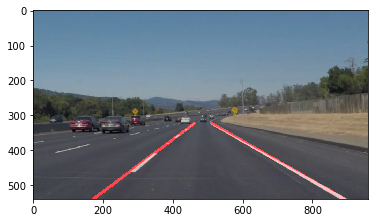

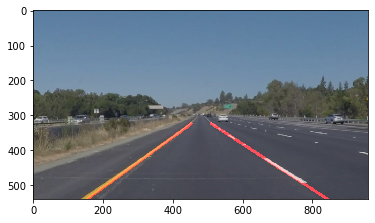

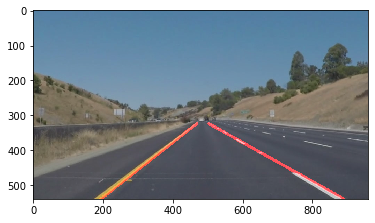

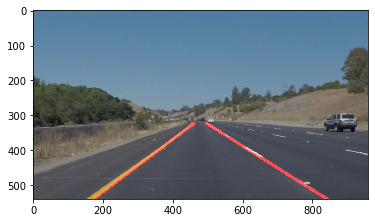

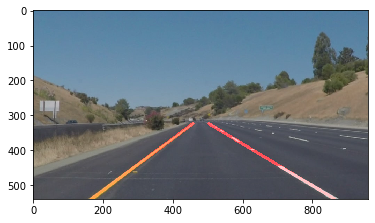

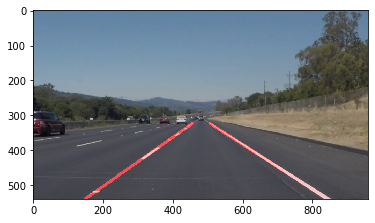

In [5]:
for img_file in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + img_file)
    plt.figure()
    plt.imshow(find_lane(img))
plt.show()



## Test on Videos

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(find_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:  11%|█▏        | 25/221 [00:00<00:00, 241.28it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 2.03 s, sys: 353 ms, total: 2.39 s
Wall time: 1.69 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(find_lane)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 6.37 s, sys: 1.09 s, total: 7.46 s
Wall time: 4.9 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(find_lane)
%time challenge_clip.write_videofile(challenge_output, audio=False)

NameError: name 'process_image' is not defined

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))